# Data

In [389]:
import pandas as pd 
data=pd.read_csv("advert.csv", index_col = "ad_id")
data.head(3)
data.shape
data.dtypes
data.nunique()

xyz_campaign_id           3
fb_campaign_id          691
age                       4
gender                    2
interest                 40
Impressions            1130
Clicks                  183
Spent                   869
Total_Conversion         32
Approved_Conversion      16
dtype: int64

# Data Cleaning

## Redefining Data Types

In [375]:
data["xyz_campaign_id"]= data["xyz_campaign_id"].astype("category")
data["fb_campaign_id"]= data["fb_campaign_id"].astype("category")
data["gender"]=data["gender"].astype("category")
data["age"]=data["age"].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 708746 to 1314415
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   xyz_campaign_id      936 non-null    category
 1   fb_campaign_id       936 non-null    category
 2   age                  936 non-null    category
 3   gender               936 non-null    category
 4   interest             936 non-null    int64   
 5   Impressions          936 non-null    int64   
 6   Clicks               936 non-null    int64   
 7   Spent                936 non-null    float64 
 8   Total_Conversion     936 non-null    int64   
 9   Approved_Conversion  936 non-null    int64   
 10  CTR                  936 non-null    float64 
 11  CPC                  936 non-null    float64 
 12  CPM                  936 non-null    float64 
 13  ROAS                 936 non-null    float64 
 14  clusters             936 non-null    int32   
 15  Conversion    

## Renaming Column Levels

In [390]:
data["xyz_campaign_id"]=data["xyz_campaign_id"].replace({916 :"A", 936:"B", 1178:"C"})

## Creating New Features and Computing Key Performance Indicators


In [391]:
data["CTR"]= round((data["Clicks"]/data["Impressions"])*100,2)
data["CPC"]= round(data["Spent"]/data["Clicks"],2)
data["CPM"]= round((data["Spent"]/data["Impressions"])*1000,2)
data["Conversion"]=data["Total_Conversion"]*5 + data["Approved_Conversion"]*100
data["ROAS"]=round((data["Total_Conversion"]*5 + data["Approved_Conversion"]*100)/data["Spent"],2)


## Filtering out Missing values

In [392]:
data=data[~data["CPC"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 708746 to 1314415
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   xyz_campaign_id      936 non-null    object 
 1   fb_campaign_id       936 non-null    int64  
 2   age                  936 non-null    object 
 3   gender               936 non-null    object 
 4   interest             936 non-null    int64  
 5   Impressions          936 non-null    int64  
 6   Clicks               936 non-null    int64  
 7   Spent                936 non-null    float64
 8   Total_Conversion     936 non-null    int64  
 9   Approved_Conversion  936 non-null    int64  
 10  CTR                  936 non-null    float64
 11  CPC                  936 non-null    float64
 12  CPM                  936 non-null    float64
 13  Conversion           936 non-null    int64  
 14  ROAS                 936 non-null    float64
dtypes: float64(5), int64(7), object

# Exploratory Analysis

<AxesSubplot:xlabel='Impressions', ylabel='Clicks'>

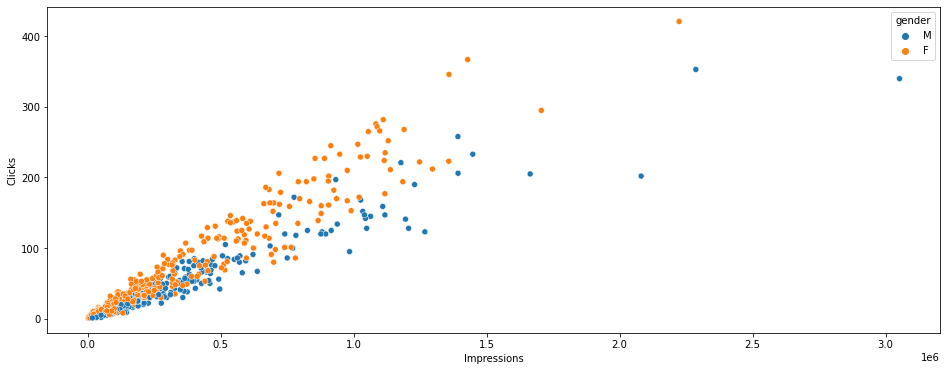

In [402]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=data, x= 'Impressions', y = 'Clicks', hue='gender')
#sns.barplot(data=data, x = 'age', y='Impressions')
#sns.barplot(data=data, x = 'age', y='Clicks')

##  Correlation Analysis - Heatmap

<AxesSubplot:>

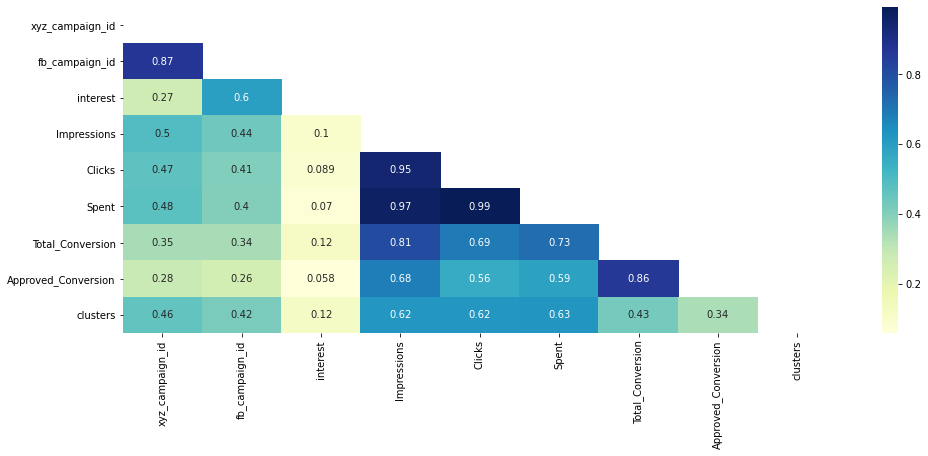

In [384]:
plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
sns.heatmap(data.corr(), annot=True,mask=mask, cmap='YlGnBu')


## Cluster Analysis 

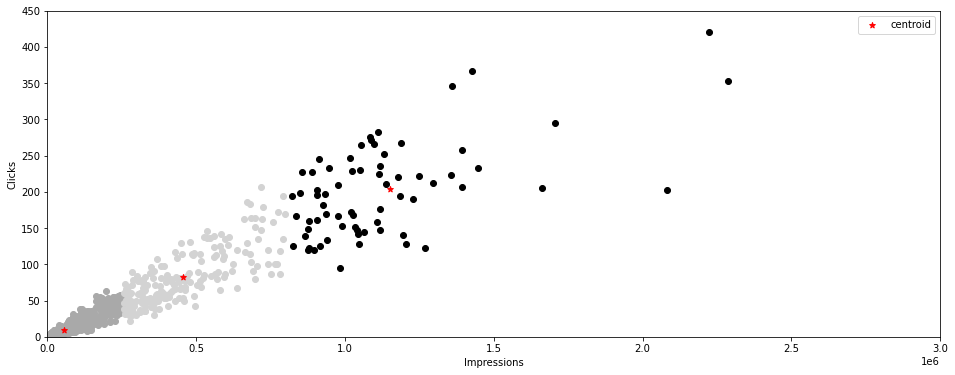

In [378]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
km  = KMeans(n_clusters =3)
km
y_predicted = km.fit_predict(data[["Impressions",'Clicks']])
data['clusters']=y_predicted
df1=data[data["clusters"]==0]
df2=data[data["clusters"]==1]
df3=data[data["clusters"]==2]
plt.figure(figsize=(16,6))
plt.scatter(df1.Impressions,df1.Clicks,color='darkgrey')
plt.scatter(df2.Impressions,df2.Clicks,color='black')
plt.scatter(df3.Impressions,df3.Clicks,color='lightgrey')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], color='red', marker='*', label='centroid')
plt.xlabel("Impressions")
plt.ylabel("Clicks")
plt.xlim((0,3e6))
plt.ylim((0,450))
plt.legend()


# The Effectiveness of Marketing Campaigns

### The Return on Ad Spent of the Campaigns

In [239]:
data["ROAS"].groupby(by=data["xyz_campaign_id"]).aggregate(fun='mean')
import pingouin as pg 
from pingouin import pairwise_ttests
pg.anova(dv = 'ROAS', between = 'xyz_campaign_id', data=data, detailed = True)
pairwise_ttests(dv = 'ROAS', between = "xyz_campaign_id", padjust = 'bonf', data = data, correction = False)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,xyz_campaign_id,A,B,False,True,0.179548,321.0,two-sided,8.576208e-01,1.000000e+00,bonf,0.194,0.032065
1,xyz_campaign_id,A,C,False,True,10.190818,646.0,two-sided,1.022622e-22,3.067865e-22,bonf,2.425e+19,1.768999
2,xyz_campaign_id,B,C,False,True,8.882610,899.0,two-sided,3.496990e-18,1.049097e-17,bonf,1.237e+15,0.634036


In [462]:
round(data["Spent"].groupby(by=data["xyz_campaign_id"]).aggregate(fun= 'median'),2)
data["Impressions"].groupby(by=[data["xyz_campaign_id"],data["age"]]).aggregate(fun= 'mean')
round(data["Spent"].groupby(by=data["xyz_campaign_id"]).aggregate(fun= 'mean'),2)
data["Clicks"].groupby(by=[data["xyz_campaign_id"]]).aggregate(fun= 'mean')
data["CTR"].groupby(by=data["xyz_campaign_id"]).aggregate(fun= 'mean')*100
data["CPC"].groupby(by=data["xyz_campaign_id"]).aggregate(fun= 'mean')
data["CPM"].groupby(by=data["xyz_campaign_id"]).aggregate(fun= 'mean')
round(data["ROAS"].groupby(by=[data["xyz_campaign_id"],data["age"]]).aggregate(fun= 'mean'),2)


,fun
xyz_campaign_id,
A,3.228571
B,6.888889
C,58.838499


## Modelling the Number of Conversions by Individual Campaigns

### The Total Conversion of Campaign A

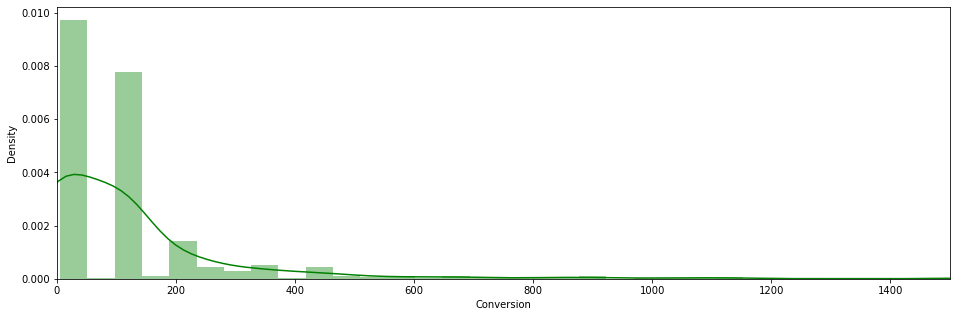

In [464]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
mask1=data[(data["xyz_campaign_id"] =="A")  | (data["Conversion"]  ) ].Conversion
sns.distplot(mask1,color='g')
plt.xlim((0,1500))
plt.show()


Text(0.5, 0, 'Conversion')

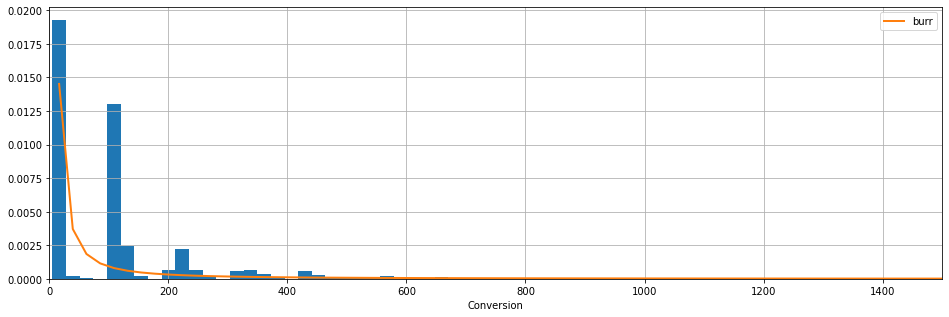

In [444]:
import fitter
plt.figure(figsize=(16,5))
f=fitter.Fitter(data= mask1, distributions = ["burr"])
f.fit()
f.summary()
plt.xlim(0,1500)
plt.xlabel('Conversion')

### The Total Conversion of Campaign B

C:\Users\Murad\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


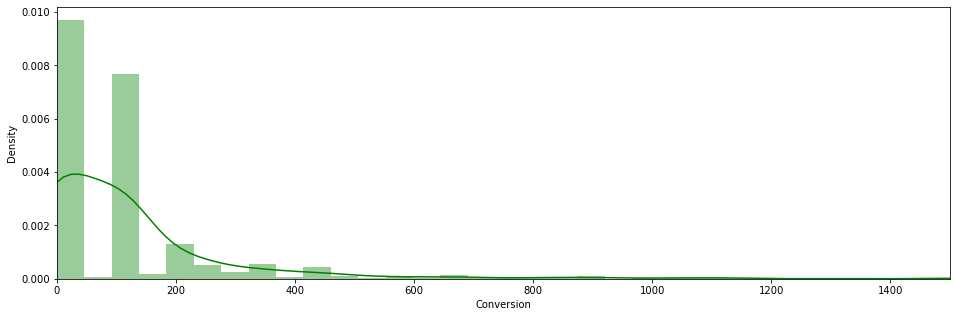

Text(0.5, 0, 'Conversion')

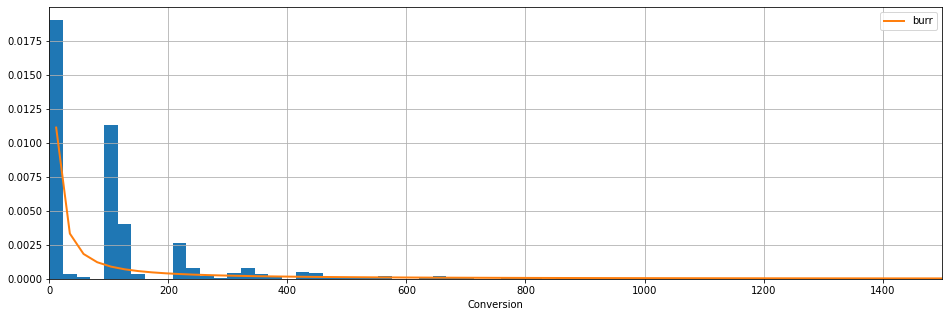

In [447]:
plt.figure(figsize=(16,5))
mask2=data[(data["xyz_campaign_id"] =="B")  | (data["Conversion"]  ) ].Conversion
sns.distplot(mask2,color='g')
plt.xlim((0,1500))
plt.show()
##----------------- Fitting Burr Distribution  -------------------------------------------------------------------
plt.figure(figsize=(16,5))
f=fitter.Fitter(data= mask2, distributions = ["burr"])
f.fit()
f.summary()
plt.xlim(0,1500)
plt.xlabel('Conversion')

### The Total Conversion of Campaign C

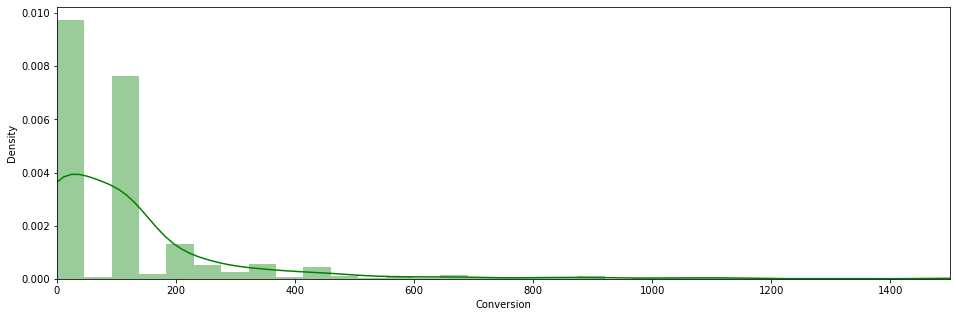

Text(0.5, 0, 'Conversion')

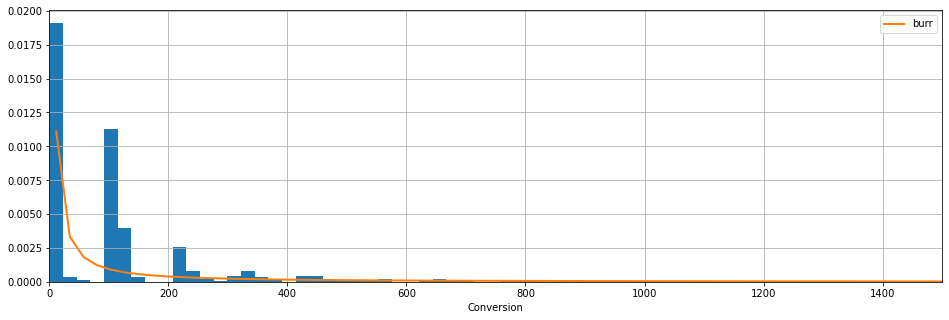

In [465]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
mask3=data[(data["xyz_campaign_id"] =="C")  | (data["Conversion"]  ) ].Conversion
sns.distplot(mask3,color='g')
plt.xlim((0,1500))
plt.show()
##----------------- Fitting Burr Distribution  -------------------------------------------------------------------
plt.figure(figsize=(16,5))
f=fitter.Fitter(data= mask3, distributions = ["burr"])
f.fit()
f.summary()
plt.xlim(0,1500)
plt.xlabel('Conversion')

## Regression Analysis

In [256]:
data_dummies = pd.get_dummies(data.drop(columns = ["fb_campaign_id"], axis = 'columns'))
data_dummies.rename({'age_30-34':'age_30_34', 'age_35-39': 'age_35_39', 'age_40-44': 'age_40_44', 'age_45-49':'age_45_49' }, axis ='columns', inplace=True)
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 708746 to 1314415
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   interest             936 non-null    int64  
 1   Impressions          936 non-null    int64  
 2   Clicks               936 non-null    int64  
 3   Spent                936 non-null    float64
 4   Total_Conversion     936 non-null    int64  
 5   Approved_Conversion  936 non-null    int64  
 6   CTR                  936 non-null    float64
 7   CPC                  936 non-null    float64
 8   CPM                  936 non-null    float64
 9   ROAS                 936 non-null    float64
 10  clusters             936 non-null    int32  
 11  Conversion           936 non-null    int64  
 12  xyz_campaign_id_A    936 non-null    uint8  
 13  xyz_campaign_id_B    936 non-null    uint8  
 14  xyz_campaign_id_C    936 non-null    uint8  
 15  age_30_34            936 non-nu

In [257]:
data_dummies=data_dummies[['xyz_campaign_id_C','xyz_campaign_id_B', 'age_30_34', 'age_35_39', 'age_40_44', 'gender_M','Spent','Clicks','Impressions']]
data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 708746 to 1314415
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   xyz_campaign_id_C  936 non-null    uint8  
 1   xyz_campaign_id_B  936 non-null    uint8  
 2   age_30_34          936 non-null    uint8  
 3   age_35_39          936 non-null    uint8  
 4   age_40_44          936 non-null    uint8  
 5   gender_M           936 non-null    uint8  
 6   Spent              936 non-null    float64
 7   Clicks             936 non-null    int64  
 8   Impressions        936 non-null    int64  
dtypes: float64(1), int64(2), uint8(6)
memory usage: 34.7 KB


In [449]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

In [450]:
X,y=data_dummies.values, data["Conversion"].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [455]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)
coeff=pd.DataFrame(regressor.coef_, data_dummies.columns, columns=["Coefficient"])
y_pred = regressor.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
coeff


RMSE: 126.87886763471055


,Coefficient
xyz_campaign_id_C,-31.815909
xyz_campaign_id_B,3.268112
age_30_34,22.453793
age_35_39,-4.797751
age_40_44,2.857881
gender_M,-0.810906
Spent,-2.124361
Clicks,-0.702683
Impressions,0.001171
